##GANs for Synthetic Data Generation

We implement a Generative Adversarial Network (GAN) in the Keras functional API. In this module we will pay attention to:

- Implementing the GAN architecture in Keras.
- Training our model.
- Using our model to generate synthetic data.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  9 07:26:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We import required libraries.

In [2]:
# from keras.datasets.mnist import load_data
from keras.datasets.cifar10 import load_data
from keras import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input,Dense,Conv2D,Flatten,Dropout,LeakyReLU,Reshape,Conv2DTranspose,BatchNormalization
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping
from statistics import mean

from matplotlib import pyplot

import numpy as np
import numpy.random as rng


As in the denoising auto-encoder module, we will be working with the MNIST data. These are 28x28 greyscale images of handwritten digits (0-9). The classes are the digit. 

This data is included in Keras.datasets library, so it is easy to load. We will expand the image dimension so that we have a single channel (as it is greyscale we have only one channel), and normalize the pixel values to real numbers between 0 and 1.

We will only work with the training data, and so will create a function that pre-processes and returns that. If you want to look at the data, examine the code in module 2.4, as this provides functions for viewing the MNIST images with their class labels.

In [3]:
def get_data ():
  # load the images into memory
  (trainX, trainy), (testX, testy) = load_data()
  # We will only really work with the trainX data.
  # Let's expand it to add channel dimension
  # X = np.expand_dims(trainX, axis=-1)
  X = trainX
  # Convert from unsigned ints to floats and scale to between 0 and 1.
  X = X.astype('float32')
  X = X / 255.0
  return X


# # Load images
# (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# # Normalize pixel values to be between 0 and 1
# train_images, test_images = train_images / 255.0, test_images / 255.0

# # Make versions of the labels that are one-hot vectors
# train_labels_array=np_utils.to_categorical(train_labels, 10)
# test_labels_array=np_utils.to_categorical(test_labels, 10)

# # Make vector of classnames
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                'dog', 'frog', 'horse', 'ship', 'truck']

We call our get data function.

In [4]:
X=get_data()

We want our discriminator to train on batches of real and fake images, learning to distinguish between the two. So we need a function to grab a set of real images from our MNIST image data.

In [5]:
# select real samples
def select_real_images(dataset, n_samples):
    # choose random instances
    indices = rng.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[indices]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

Now let us define a function to create our discriminator model. We will also compile it within the function, so if you want to play around with the optimizer change the code in here.

In [6]:
def conv_block(input_layer,filters,kernel_size,strides):
    # Implement a BN-ReLU-Conv block
    # refering paper https://arxiv.org/pdf/1603.05027.pdf

    conv = Conv2D(filters,kernel_size, strides, padding='same')(input_layer)
    batch = BatchNormalization()(conv)
    act = LeakyReLU(alpha=.2)(batch)
    # drop = Dropout(0.5)(conv)
    return act

In [7]:
def get_discriminator(in_shape=(32,32,3)):
# def get_discriminator(in_shape=(28,28,1)):
  # Define Model
  # This is a basic binary classification CNN
  inputs=Input(in_shape)
  
  # conv1=Conv2D(128, 3, strides=2, padding='same')(inputs)
  # leak1=LeakyReLU(alpha=.2)(conv1)
  # drop1=Dropout(.4)(leak1)
  # conv1 = conv_block(inputs,128,3,1)
  conv2 = conv_block(inputs,128,5,2)
  conv3 = conv_block(conv2,64,3,2)
  # conv4 = conv_block(conv3,64,5,1)
  
  # conv2=Conv2D(64, 3, strides=2, padding='same')(drop1)
  # leak2=LeakyReLU(alpha=.2)(conv2)
  # drop2=Dropout(.4)(leak2)
  
  flat=Flatten()(conv3)
  outputs=Dense(1,activation='sigmoid')(flat)
  
  # Create Model
  model=Model(inputs=inputs,outputs=outputs)
  
  # Compile model
  opt = Adam(lr=0.0001, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

If you wish, run the following code block to create an instance of the discriminator model in order to view a summary.

Note we will create the discriminator instance we use for the problem in a later code block.

In [8]:
# Get the discriminator
discriminator = get_discriminator()
# View a summary of the discriminator
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0     

In [9]:
def conv_trans_block(input_layer,filters,kernel_size,strides):
    # Implement a BN-ReLU-Conv_Transpose block
    # refering paper https://arxiv.org/pdf/1603.05027.pdf

    conv = Conv2DTranspose(filters,kernel_size, strides, padding='same')(input_layer)
    batch = BatchNormalization()(conv)
    act = LeakyReLU(alpha=.2)(batch)
    # drop = Dropout(0.5)(conv)
    return act

In [10]:
def get_generator(noise_dim=100):
    # Define the generator model
    inputs=Input((noise_dim,))
    
    # Create a basis for 8x8 image
    # We are using the noise to generate 128 high level 'feature maps' in a 7x7 space
    n = 128 * 8 * 8
    # n = 128 * 7 * 7
    dense = Dense(n)(inputs)
    leak1 = LeakyReLU(alpha=0.2)(dense)
    reshape = Reshape((8, 8, 128))(leak1)
    # reshape = Reshape((7, 7, 128))(leak1)
    
    # Now we extract lower level features...
    # Upsample to 16x16
    # conv_tran1 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(reshape)
    # leak2=LeakyReLU(alpha=0.2)(conv_tran1)
    conv_tran1 = conv_trans_block(reshape,128,3,2)
    conv_tran1a = conv_trans_block(conv_tran1,128,7,1)
    conv_tran1b = conv_trans_block(conv_tran1a,128,5,1)
    conv_tran1c = conv_trans_block(conv_tran1b,128,3,1)
    
    # Now we extract even lower level features...
    # Upsample to 32x32
    # conv_tran2 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(leak2)
    # leak3 = LeakyReLU(alpha=0.2)(conv_tran2)
    conv_tran2 = conv_trans_block(conv_tran1c,64,3,2)
    conv_tran2a = conv_trans_block(conv_tran2,64,7,1)
    conv_tran2b = conv_trans_block(conv_tran2a,64,5,1)
    conv_tran2c = conv_trans_block(conv_tran2b,64,3,1)
    
    # Finally we put togeather our pixel values for the synthetic image
    outputs = Conv2D(3, (8,8), activation='sigmoid', padding='same')(conv_tran2a)
    # outputs = Conv2D(1, (7,7), activation='sigmoid', padding='same')(conv_tran2a)
    
    # Create the model and return it
    model=Model(inputs=inputs,outputs=outputs)
    return model

If you wish, run the following code block to create an instance of the generator model in order to view a summary. You can change the dimension of the noise vector if you like.

Note we will create the generator instance we use for the problem in a later code block.

In [11]:
# Specify the dimension of the noise vector
noise_dim = 300
# Get the generator model
generator = get_generator(noise_dim)
# Summarize the model
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              2465792   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0   

Obviously we want to generate this noise from something simple so that we can sample from the same distribution later. So we use simple independent Gaussian noise.

We create a function that will generate as many of these noise vectors as we wish.

In [12]:
# Generate independent Gaussian noise as input for the generator
def generate_input_noise(noise_dim, num_vectors):
    # Generate independent Gaussian noise
    noise_input = rng.standard_normal(noise_dim * num_vectors)
    # Reshape into a 2d array
    noise_input = noise_input.reshape(num_vectors, noise_dim)
    return noise_input

Now we create a function to generate fake images from the noise vectors using the generator. We will also get this function to return labels indicating that the images are fake (we represent this by 0).

In [13]:
# Generate n fake images using the generator
def generate_fake_images(generator, noise_dim, n_images):
    # Generate noise vectors
    noise = generate_input_noise(noise_dim, n_images)
    # Use generator to create fake images from noise vectors
    fakes = generator.predict(noise)
    # create 'fake' class labels (0)
    labels = np.zeros((n_images, 1))
    return fakes, labels

Let's also create a function that plot's fake images created by the generator so we look at them.

In [14]:
# Plot fake images created by generator from random noise
def plot_generated_images(generator,noise_dim=100,n_images=25):
    # Create the fake images (we don't need the labels here)
    X, _ = generate_fake_images(generator, noise_dim, n_images)
    # Plot the fake images
    for i in range(n_images):
        pyplot.subplot(5, 5, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, :])
        # pyplot.imshow(X[i, :, :, 0],cmap='gray')
    pyplot.show()

Now we will create a function to make our GAN. This will involve putting the discriminator and generator together into a single model. We will also want to be able to treat them as individual models as well, so we will return (1) the discriminator, (2) the generator, and (3) the combined GAN.

Note that we will make the weights in the discriminator non-trainable in the combined GAN model. This means that when we train the GAN we are actually only optimizing the weights in the generator. I discuss this further after we define the train function below.

Once again, we will compile the model in the function. This is the optimizer that will be used for training the generator (because of the above). If you want to play around with the optimizer change the code inside the function.

In [15]:
# Create the discriminator, generator and GAN networks.
# Compile networks requiring compilation within function.
def get_gan_models(noise_dim=100):
    # Create the discriminator (compiled internally)
    discriminator = get_discriminator()
    # Create the generator
    generator = get_generator(noise_dim)
    
    # Make weights in the discriminator not trainable
    discriminator.trainable = False
    
    # Make GAN
    inputs = Input((noise_dim,))
    gan = Model(inputs,discriminator(generator(inputs)))
    
    # Compile model
    opt = Adam(lr=0.0001, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    
    return discriminator,generator,gan

Now let's finally get our networks. If you want to change the noise dimension we work with in the problem, change the value here.

In [16]:
noise_dim=300
discriminator,generator,gan=get_gan_models(noise_dim)

We are going to code a manual implementation of the training loop. This is so we can implement appropriate training for the discriminater and generator.

Note we do not use validation data, and such data makes little sense in this context.

In [17]:
#Iter 3
# Train the generator and discriminator
def train(
    gan, 
    generator,
    discriminator,
    dataset, 
    noise_dim=300, 
    epochs=500, 
    batch_size=512
):
    # We keep the amount of work done per 'epoch' matching
    # the dataset size, though in reality this is quite arbitrary.
    batches_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # Iterate through desired number of epochs
    for i in range(epochs):
      # Iterate through batches
      d_loss_list = []
      g_loss_list = []
      for j in range(batches_per_epoch):
        # Train the discriminator            
        # Get randomly selected real images
        X_real, Y_real = select_real_images(dataset, half_batch)
        # Generate fake images
        X_fake, Y_fake = generate_fake_images(generator, noise_dim, half_batch)
        # Create training set for the discriminator
        X, Y = np.vstack((X_real, X_fake)), np.vstack((Y_real, Y_fake))
        # Update discriminator model weights
        d_loss, _ = discriminator.train_on_batch(X, Y)
        d_loss_list.append(d_loss) 

        # Train the generator
        # Prepare input noise
        X_gan = generate_input_noise(noise_dim, batch_size)
        # Create inverted labels for the fake samples
        # This is because the GAN/generator is trying to get the discriminator
        # to classify these fake images as real.
        Y_gan = np.ones((batch_size, 1))
        # Update the generator weights via the discriminator's error
        # Remember the discriminator's weights are fixed in the GAN,
        # so these will not be adjusted.
        g_loss = gan.train_on_batch(X_gan, Y_gan)
        g_loss_list.append(g_loss)


        # Give information about loss on this batch
        # print("Epoch: {} Batch: {}/{} Disc. Loss: {:06.5f} Gen. Loss: {:06.5f}".format(i+1, j+1,batches_per_epoch, d_loss, g_loss))
        # print("Epoch: {} Batch: {}/{}".format(i+1, j+1,batches_per_epoch))


      # Epoch performance
      print('Epoch: {}, Discriminator loss min:{:06.5f}, Generator loss min:{:06.5f}'.format(i+1,min(d_loss_list),min(g_loss_list)))
      if not i%5:
        plot_generated_images(generator,noise_dim,25)
        # gpu_info = !nvidia-smi
        # gpu_info = '\n'.join(gpu_info)
        # print(gpu_info)

In [19]:
train(gan,generator,discriminator,X)

KeyboardInterrupt: ignored

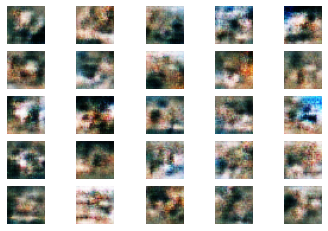

In [25]:
#Iter 3, after 100 epochs
plot_generated_images(generator,100,25)

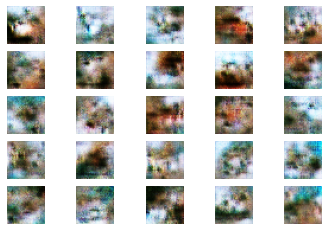

In [19]:
#Iter 3, after 500 epochs
plot_generated_images(generator,300,25)

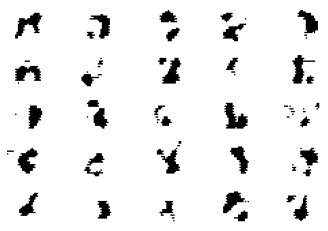

In [22]:
#Iter 2, after 40 epochs, generator loss is 0.06308
plot_generated_images(generator,100,25)